In [1]:
dataset_name = "exchange-2_cpm_results"
path = "data/" + dataset_name + ".csv"
gaussian_window_size = 1024

In [2]:
import adclasses
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Preprocess Dataset

In [3]:
data = pd.read_csv(path, header=0)
data = data.dropna()
start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)
data["timestamp"] = pd.to_datetime(data["timestamp"], format="%Y-%m-%d %H:%M:%S")

print("Missing time stamps: \n", adclasses.find_missing_time_steps(start_date, end_date, '1H', data))

data =data.drop_duplicates(subset="timestamp")

data["timestamp"] = pd.to_datetime(data["timestamp"], format="%Y-%m-%d %H:%M:%S")
ad = adclasses.UnivariateAnomalyDetection(dataframe=data, timestep="1H", dateformat="%Y-%m-%d %H:%M:%S", name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Start Date: ", start_date)
print("End Date: ", end_date)
print("Date Format: ", ad.get_dateformat())
true_outlier_dates = ["2011-07-26 06:00:01",
                      "2011-08-10 17:00:01"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)

Start date:  2011-07-01 00:00:01
End date:  2011-09-07 15:00:01
Missing time stamps: 
 DatetimeIndex(['2011-07-21 05:00:01', '2011-08-08 18:00:01',
               '2011-08-10 16:00:01', '2011-08-15 22:00:01',
               '2011-08-15 23:00:01', '2011-09-01 19:00:01',
               '2011-09-01 20:00:01', '2011-09-01 21:00:01',
               '2011-09-01 22:00:01', '2011-09-01 23:00:01',
               '2011-09-02 00:00:01', '2011-09-02 01:00:01',
               '2011-09-02 02:00:01', '2011-09-02 03:00:01',
               '2011-09-02 04:00:01', '2011-09-02 05:00:01',
               '2011-09-02 06:00:01', '2011-09-02 07:00:01',
               '2011-09-02 08:00:01', '2011-09-02 09:00:01',
               '2011-09-02 10:00:01', '2011-09-02 11:00:01',
               '2011-09-02 12:00:01', '2011-09-02 13:00:01',
               '2011-09-02 14:00:01'],
              dtype='datetime64[ns]', freq=None)
Length:  1648
Time step size:  1H
Start Date:  2011-07-01 00:00:01
End Date:  2011-09-07 15:0

# GLM

In [4]:
# optimize
etas = [.5,1]
lambdas = [.99, .999, .9999]

opt_dict = {}

for eta in etas:
    for lambda_ in lambdas:
       
        mse = ad.glm(gaussian_window_size=gaussian_window_size, 
                     family='gaussian', 
                     eta=eta, 
                     lambda_=lambda_)["MSE"]

        print("eta: ", eta)
        print("lambda: ", lambda_)
        print("MSE: ",mse)

        key_str = "eta " + str(eta) + " lambda " + str(lambda_)

        opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

  0%|          | 0/1623 [00:00<?, ?it/s]

Initial Mean 0.3235007312871061
Initial StdDev 0.16718623968120033


100%|██████████| 1623/1623 [00:00<00:00, 14919.09it/s]

eta:  0.5
lambda:  0.99
MSE:  0.010033210235003713
Initial Mean 0.3235007312871061
Initial StdDev 0.16718623968120033



100%|██████████| 1623/1623 [00:00<00:00, 17263.53it/s]

eta:  0.5
lambda:  0.999
MSE:  0.014971682771546316
Initial Mean 0.3235007312871061
Initial StdDev 0.16718623968120033



100%|██████████| 1623/1623 [00:00<00:00, 15941.39it/s]

eta:  0.5
lambda:  0.9999
MSE:  0.01605250659133737
Initial Mean 0.3235007312871061
Initial StdDev 0.16718623968120033



100%|██████████| 1623/1623 [00:00<00:00, 18117.15it/s]

eta:  1
lambda:  0.99
MSE:  0.008025165197130837
Initial Mean 0.3235007312871061
Initial StdDev 0.16718623968120033



100%|██████████| 1623/1623 [00:00<00:00, 13939.02it/s]

eta:  1
lambda:  0.999
MSE:  0.01244446976428421
Initial Mean 0.3235007312871061
Initial StdDev 0.16718623968120033


eta:  1
lambda:  0.9999
MSE:  0.01387224026936332

best params:  eta 1 lambda 0.99


100%|██████████| 1623/1623 [00:00<00:00, 17927.35it/s]

Initial Mean 0.3235007312871061
Initial StdDev 0.16718623968120033


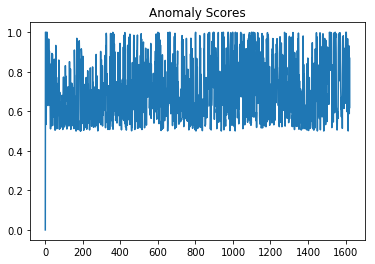

Time:  0.395444393157959


['anomaly_scores/GLM/exchange-2_cpm_results_no_fill']

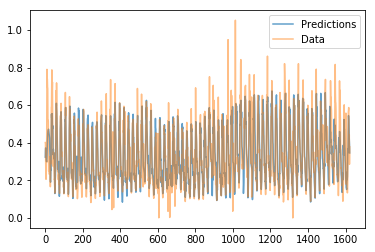

In [5]:
save_path = "anomaly_scores/GLM/" + dataset_name+ "_no_fill"
output_dict = ad.glm(gaussian_window_size=gaussian_window_size, family='gaussian', 
                     eta=int(best_params[4:6]),
                     lambda_=float(best_params[14:]),
                     plot_anomaly_scores=True, plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# SARIMA


 Fitting models using approximations to speed things up...

 Regression with ARIMA(2,1,2) errors : -757.5598
 Regression with ARIMA(0,1,0) errors : -736.4275
 Regression with ARIMA(1,1,0) errors : -750.4283
 Regression with ARIMA(0,1,1) errors : -773.3494
 ARIMA(0,1,0)                    : -738.9863
 Regression with ARIMA(1,1,1) errors : -754.0183
 Regression with ARIMA(0,1,2) errors : -776.2634
 Regression with ARIMA(1,1,2) errors : -748.2525
 Regression with ARIMA(0,1,3) errors : -771.1549
 Regression with ARIMA(1,1,3) errors : -747.4227
 ARIMA(0,1,2)                    : -782.1607
 ARIMA(0,1,1)                    : -776.4115
 ARIMA(1,1,2)                    : -778.7242
 ARIMA(0,1,3)                    : -778.9901
 ARIMA(1,1,1)                    : -764.451
 ARIMA(1,1,3)                    : -778.6467

 Now re-fitting the best model(s) without approximations...

 ARIMA(0,1,2)                    : -790.8411

 Best model: Regression with ARIMA(0,1,2) errors 



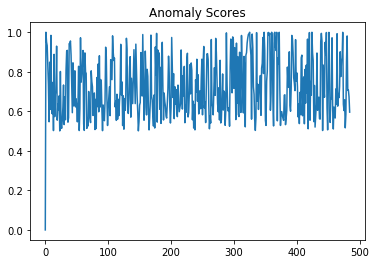

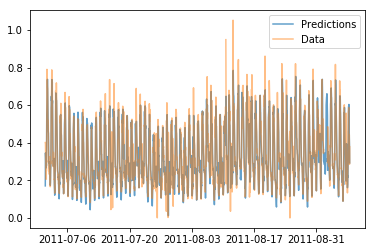

Time:  13.130933284759521


['anomaly_scores/SARIMA_auto/exchange-2_cpm_results_no_fill']

In [6]:
save_path = "anomaly_scores/SARIMA_auto/" + dataset_name+ "_no_fill"
output_dict = ad.sarimax(gaussian_window_size=gaussian_window_size, step_size=100, auto=True,
                         use_exog=True, s=24, plot_anomaly_scores=True,plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# Prophet

In [7]:
# optimization step

step_sizes = [100, 200]
seasonality_prior_scales = [1, 5, 10, 15, 20]
seasonality_modes = ["additive", "multiplicative"]
changepoint_prior_scales = [.01, .05, .1, .15, .2]
opt_dict = {}

for step_size in step_sizes:
    for seasonality_prior_scale in seasonality_prior_scales:
        for seasonality_mode in seasonality_modes:
            for changepoint_prior_scale in changepoint_prior_scales:
                
                mse = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                          daily_seasonality=True, 
                                          seasonality_prior_scale=seasonality_prior_scale,
                                          seasonality_mode=seasonality_mode,
                                          changepoint_prior_scale=changepoint_prior_scale,
                                          step_size=step_size,
                                          optimize=True)
                print("Step Size: ", step_size)
                print("Seasonality Prior Scale: ", seasonality_prior_scale)
                print("Seasonality Mode: ", seasonality_mode)
                print("Changepoint Prior Scale: ", changepoint_prior_scale)
                print("MSE: ",mse)
                
                key_str = "Step Size " + str(step_size) + " Seasonality Prior Scale " + str(seasonality_prior_scale) +" Seasonality Mode " + str(seasonality_mode) +" Changepoint Prior Scale" + str(changepoint_prior_scale)
                
                opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.003013743387634357


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.0021443806297420957


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0012987573467299264


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.00114001609539586


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.0010878688579960532


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.003540134794985155


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0019785039191441657


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0014473741141185525


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0013474264540307064


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0013207846678393352


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.0029941776703389755


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.0021511969277678523


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.001226326315778698


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0011512284178264412


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.0010905502423754223


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.0034746631354914416


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0021693442000483183


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0014466109590987497


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0013566998381077723


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0013264788418073808


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.0030007968156212095


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.002031162152033533


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0012469249567165779


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0011466560916827888


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.001090105163399164


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.0033925909386899205


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0020502796619378135


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.001450968554856481


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0013576693026138525


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.001334024508062985


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.0029989767257942745


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.0021241747539589672


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.001289496247038798


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0011445326410769784


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.0010951127577487698


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.0034105288491356363


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0020387842717261013


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0014621643779952644


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0013397869195408293


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0013182072424351347


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.0030154579690272543


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.002108758022320544


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.001252583264279233


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0011439916974888774


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.001100901287258067


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.003445592843252718


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.001926219745367356


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0014306567630377116


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.001349866825868928


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  100
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0013269577168412059


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.003013743387634357


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.0021443806297420957


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0012987573467299264


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.00114001609539586


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.0010878688579960532


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.003540134794985155


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0019785039191441657


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0014473741141185525


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0013474264540307064


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  1
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0013207846678393352


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.0029941776703389755


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.0021511969277678523


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.001226326315778698


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0011512284178264412


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.0010905502423754223


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.0034746631354914416


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0021693442000483183


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0014466109590987497


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0013566998381077723


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  5
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0013264788418073808


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.0030007968156212095


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.002031162152033533


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.0012469249567165779


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0011466560916827888


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.001090105163399164


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.0033925909386899205


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0020502796619378135


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.001450968554856481


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0013576693026138525


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  10
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.001334024508062985


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.0029989767257942745


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.0021241747539589672


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.001289496247038798


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0011445326410769784


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.0010951127577487698


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.0034105288491356363


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.0020387842717261013


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0014621643779952644


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.0013397869195408293


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  15
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0013182072424351347


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.01
MSE:  0.0030154579690272543


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.05
MSE:  0.002108758022320544


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.1
MSE:  0.001252583264279233


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.15
MSE:  0.0011439916974888774


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  additive
Changepoint Prior Scale:  0.2
MSE:  0.001100901287258067


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.01
MSE:  0.003445592843252718


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.05
MSE:  0.001926219745367356


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.1
MSE:  0.0014306567630377116


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.15
MSE:  0.001349866825868928
Step Size:  200
Seasonality Prior Scale:  20
Seasonality Mode:  multiplicative
Changepoint Prior Scale:  0.2
MSE:  0.0013269577168412059

best params:  Step Size 100 Seasonality Prior Scale 1 Seasonality Mode additive Changepoint Prior Scale0.2


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


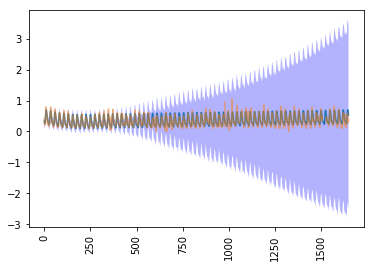

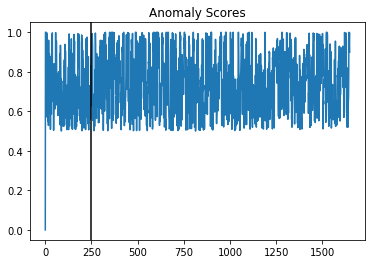

Time:  19.70900583267212


['anomaly_scores/Prophet/exchange-2_cpm_results_no_fill']

In [8]:
save_path = "anomaly_scores/Prophet/" + dataset_name+ "_no_fill"
output_dict = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                  daily_seasonality=True, 
                                  seasonality_prior_scale=1,
                                  seasonality_mode="additive",
                                  changepoint_prior_scale=.2,
                                  step_size=100,
                                  plot_forecast=True,
                                  plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# STL Resid

In [9]:
# optimization step
swindows = ["periodic", 5,7,9,11]
sdegrees = [0,1,2]
twindows = [5,7,9,11]
tdegrees = [0,1,2]
inners = [1,2,3]
outers = [0,1]
opt_dict = {}

for swindow in swindows:
    for sdegree in sdegrees:
        for twindow in twindows:
            for tdegree in tdegrees:
                for inner in inners:
                    for outer in outers:
                        
                        print("swindow: ", swindow)
                        print("sdegree: ", sdegree)
                        print("twindow: ", twindow)
                        print("tdegree: ", tdegree)
                        print("inner: ", inner)
                        print("outer: ", outer)
                        
                        
                        try:
  
                            stl_resid_sum = ad.stl_resid(gaussian_window_size=gaussian_window_size, step_size=100,n_periods=24, swindow=swindow, 
                                                         sdegree=sdegree, twindow=twindow, tdegree=tdegree, inner=inner, 
                                                         outer=outer, fill_option="linear", optimize=True)


                            print("STL Resid Sum: ",stl_resid_sum)

                            key_str = "swindow " + str(swindow) + " sdegree " + str(sdegree) +" twindow " + str(twindow) +" tdegree " + str(tdegree) +" inner " + str(inner) +" outer " + str(outer)

                            opt_dict[key_str] = stl_resid_sum

                        except:
                            print("Fail")
                            continue

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.11283500819397278
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.11326598901534908
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.11280257285345
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.11283500819397278
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.11279073135783622
swindow:  periodic
sdegree:  0
twindow:  5
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.11281245958622607
swindow

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.1392932434563489
swindow:  periodic
sdegree:  0
twindow:  9
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.13857243491475313
swindow:  periodic
sdegree:  0
twindow:  9
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.138560033097598
swindow:  periodic
sdegree:  0
twindow:  9
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.1385906947225745
swindow:  periodic
sdegree:  0
twindow:  9
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.1385602210317642
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.25054399312509146
swindow:  periodic
sdegree:  0
twindow:  11
tdegree:  0
inner:  1
outer:  1
247
R stlpl

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.1731117800392783
swindow:  periodic
sdegree:  1
twindow:  7
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.173090679236091
swindow:  periodic
sdegree:  1
twindow:  7
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.17308200479328892
swindow:  periodic
sdegree:  1
twindow:  7
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.08539659485851242
swindow:  periodic
sdegree:  1
twindow:  7
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.0857615465006947
swindow:  periodic
sdegree:  1
twindow:  7
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.08537684708856236
swindow:  periodic
sdegree:  1
twindow:  7
tdegree:  2
inner:  2
outer:  1
247
R stlplu

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.11281245958622607
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.11261228664064951
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.11312983270843822
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.11259824261271076
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.11261228664064951
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.11260591508792335
swindow:  periodic
sdegree:  2
twindow:  5
tdegree:  1
inner:  3
outer:  1
247
R st

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.2516763005483774
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.25017854838342257
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.25054399312509146
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.2499775457255982
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.25032873855231325
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.23082016165813368
swindow:  periodic
sdegree:  2
twindow:  11
tdegree:  1
inner:  1
outer:  1
247


R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.050238362574896084
swindow:  5
sdegree:  0
twindow:  7
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.04995639684599747
swindow:  5
sdegree:  0
twindow:  9
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.13106778313887327
swindow:  5
sdegree:  0
twindow:  9
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.12880778501938703
swindow:  5
sdegree:  0
twindow:  9
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.13129615286084237
swindow:  5
sdegree:  0
twindow:  9
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.13106778313887327
swindow:  5
sdegree:  0
twindow:  9
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill.

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  5.061315964424539e-06
swindow:  5
sdegree:  1
twindow:  5
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  2.0894803597484136e-05
swindow:  5
sdegree:  1
twindow:  5
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  1.534897632061272e-06
swindow:  5
sdegree:  1
twindow:  5
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  9.970007185019001e-06
swindow:  5
sdegree:  1
twindow:  7
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.08373772524384925
swindow:  5
sdegree:  1
twindow:  7
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.08254839141471738
swindow:  5
sdegree:  1
twindow:  7
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247  missing. wi

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.08455860578437724
swindow:  5
sdegree:  1
twindow:  11
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.08375409384832212
swindow:  5
sdegree:  1
twindow:  11
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.08497446107133172
swindow:  5
sdegree:  1
twindow:  11
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.08455860578437724
swindow:  5
sdegree:  1
twindow:  11
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.08509413074777995
swindow:  5
sdegree:  1
twindow:  11
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.08484866510903236
swindow:  5
sdegree:  2
twindow:  5
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will f

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.01540490974781843
swindow:  5
sdegree:  2
twindow:  9
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.01525727542770754
swindow:  5
sdegree:  2
twindow:  9
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.009837488317935676
swindow:  5
sdegree:  2
twindow:  9
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.008853078693770144
swindow:  5
sdegree:  2
twindow:  9
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.010131593398507948
swindow:  5
sdegree:  2
twindow:  9
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.009837488317935676
swindow:  5
sdegree:  2
twindow:  9
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fi

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.14212049179492006
swindow:  7
sdegree:  0
twindow:  7
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.14149268111696858
swindow:  7
sdegree:  0
twindow:  7
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.14224699762312482
swindow:  7
sdegree:  0
twindow:  7
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.14196492988504267
swindow:  7
sdegree:  0
twindow:  7
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.06821411327571547
swindow:  7
sdegree:  0
twindow:  7
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.06785571295447766
swindow:  7
sdegree:  0
twindow:  7
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. 

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.08117399382558316
swindow:  7
sdegree:  1
twindow:  5
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.08086189298708336
swindow:  7
sdegree:  1
twindow:  5
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.08163153787377467
swindow:  7
sdegree:  1
twindow:  5
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.08117399382558316
swindow:  7
sdegree:  1
twindow:  5
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.08172031537325752
swindow:  7
sdegree:  1
twindow:  5
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.08151102078609815
swindow:  7
sdegree:  1
twindow:  5
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. 

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.16484892513945873
swindow:  7
sdegree:  1
twindow:  11
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.16532446793427208
swindow:  7
sdegree:  1
twindow:  11
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.15863633769931626
swindow:  7
sdegree:  1
twindow:  11
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.15848095604541643
swindow:  7
sdegree:  1
twindow:  11
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.1585480027995094
swindow:  7
sdegree:  1
twindow:  11
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.15863633769931626
swindow:  7
sdegree:  1
twindow:  11
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will f

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.08482824549460062
swindow:  7
sdegree:  2
twindow:  9
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.08447539897274307
swindow:  7
sdegree:  2
twindow:  9
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.08488126810754028
swindow:  7
sdegree:  2
twindow:  9
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.08474623728883932
swindow:  7
sdegree:  2
twindow:  9
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.08453080200142575
swindow:  7
sdegree:  2
twindow:  9
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.08383097863980364
swindow:  7
sdegree:  2
twindow:  9
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. 

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.15931633179784582
swindow:  9
sdegree:  0
twindow:  7
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.15868936259715644
swindow:  9
sdegree:  0
twindow:  7
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.15972216238578957
swindow:  9
sdegree:  0
twindow:  7
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.15931633179784582
swindow:  9
sdegree:  0
twindow:  7
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.15978699277424913
swindow:  9
sdegree:  0
twindow:  7
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.15961635175310182
swindow:  9
sdegree:  0
twindow:  7
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. 

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.15785170711359142
swindow:  9
sdegree:  0
twindow:  11
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.15775413163897403
swindow:  9
sdegree:  1
twindow:  5
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.09572771090286232
swindow:  9
sdegree:  1
twindow:  5
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.09525987311393706
swindow:  9
sdegree:  1
twindow:  5
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.09589236860952705
swindow:  9
sdegree:  1
twindow:  5
tdegree:  0
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.09572771090286232
swindow:  9
sdegree:  1
twindow:  5
tdegree:  0
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill.

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.11542432401738424
swindow:  9
sdegree:  1
twindow:  9
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.11519509948959462
swindow:  9
sdegree:  1
twindow:  9
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.11547121626466836
swindow:  9
sdegree:  1
twindow:  9
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.11535978602844787
swindow:  9
sdegree:  1
twindow:  11
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.1963881682968842
swindow:  9
sdegree:  1
twindow:  11
tdegree:  0
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.19648735445401191
swindow:  9
sdegree:  1
twindow:  11
tdegree:  0
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.04923293505026134
swindow:  9
sdegree:  2
twindow:  7
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.0502961547252164
swindow:  9
sdegree:  2
twindow:  7
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.04958737198624485
swindow:  9
sdegree:  2
twindow:  7
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.04923293505026134
swindow:  9
sdegree:  2
twindow:  7
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.04965319034531266
swindow:  9
sdegree:  2
twindow:  7
tdegree:  2
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.04952672048154629
swindow:  9
sdegree:  2
twindow:  9
tdegree:  0
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. T

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.1088472840890424
swindow:  11
sdegree:  0
twindow:  5
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.10874824455116738
swindow:  11
sdegree:  0
twindow:  5
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  7.079475404796454e-05
swindow:  11
sdegree:  0
twindow:  5
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  7.400667767341095e-05
swindow:  11
sdegree:  0
twindow:  5
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  5.841125258839943e-05
swindow:  11
sdegree:  0
twindow:  5
tdegree:  2
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  7.079475404796454e-05
swindow:  11
sdegree:  0
twindow:  5
tdegree:  2
inner:  3
outer:  0
247
R stlplus completed: 247  missing

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.2169115517914262
swindow:  11
sdegree:  0
twindow:  11
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.21610381345892654
swindow:  11
sdegree:  0
twindow:  11
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.2169894641129958
swindow:  11
sdegree:  0
twindow:  11
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.21671361669896522
swindow:  11
sdegree:  0
twindow:  11
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.16382466311028437
swindow:  11
sdegree:  0
twindow:  11
tdegree:  2
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.1638703592801065
swindow:  11
sdegree:  0
twindow:  11
tdegree:  2
inner:  2
outer:  0
247
R stlplus completed: 247  missing. wi

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.18235956984104204
swindow:  11
sdegree:  1
twindow:  9
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.18326127757959657
swindow:  11
sdegree:  1
twindow:  9
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.182344312838821
swindow:  11
sdegree:  1
twindow:  9
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.18235956984104204
swindow:  11
sdegree:  1
twindow:  9
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.18234715475573365
swindow:  11
sdegree:  1
twindow:  9
tdegree:  1
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.18234397849412595
swindow:  11
sdegree:  1
twindow:  9
tdegree:  2
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fi

R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.12692727236690005
swindow:  11
sdegree:  2
twindow:  7
tdegree:  0
inner:  3
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.12687486837390743
swindow:  11
sdegree:  2
twindow:  7
tdegree:  1
inner:  1
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.1265208374686654
swindow:  11
sdegree:  2
twindow:  7
tdegree:  1
inner:  1
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.12605006535954333
swindow:  11
sdegree:  2
twindow:  7
tdegree:  1
inner:  2
outer:  0
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.12685842200818254
swindow:  11
sdegree:  2
twindow:  7
tdegree:  1
inner:  2
outer:  1
247
R stlplus completed: 247  missing. will fill. True
STL Resid Sum:  0.1265208374686654
swindow:  11
sdegree:  2
twindow:  7
tdegree:  1
inner:  3
outer:  0
247
R stlplus completed: 247  missing. will fi

In [10]:
save_path = "anomaly_scores/stl/" + dataset_name+ "_no_fill"
output_dict = ad.stl_resid(gaussian_window_size=gaussian_window_size, step_size=100,n_periods=24, swindow=7, 
             sdegree=2, twindow=5, tdegree=2, inner=3, 
             outer=0, fill_option="linear", optimize=False)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

1648
R stlplus completed: 1648  missing. will fill. True
Time:  1.6717538833618164


['anomaly_scores/stl/exchange-2_cpm_results_no_fill']